In [1]:
 from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = 'drive/My Drive/data'

In [4]:
import pandas as pd

In [5]:
try:
    df = pd.read_csv(path+'/13GEN.csv', encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(path+'/13GEN.csv', encoding='ISO-8859-1')
print(df.shape)

(778, 6)


In [6]:
df.head(500)

,ID,Name,Stars,Title,Date,Description
0,1.0,Yeng,1,DO NOT GET,NaN,i'd say donât get this unless you want your ...
1,2.0,Amazon User,1,Crashes frequently,NaN,CPU crashed frequently on my Asus Strix ROG Z7...
2,3.0,Old Audio Nut,1,It came USED.,NaN,"The box was opened, the i5 sticker was missing..."
3,4.0,Andre in the north,1,Product never worked after installation,NaN,Product never worked after finally building sy...
4,5.0,Jypsy Martin,1,Product was defect,NaN,I returned it and ask for a refund the 6 of Oc...
...,...,...,...,...,...,...
495,496.0,FloncH,5,Por ahora perfecto,NaN,"For now, the processor is performing everythin..."
496,497.0,L&S,5,I7 13900KF,NaN,Juste incroyable rien a dire de plus
497,498.0,artyz,5,TrÃ¨s performant,NaN,"Very efficient processor in gaming,"
498,499.0,Andrii Sobol,5,"Good product, great quality.",NaN,"Good product, great quality."


In [7]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from scipy.special import softmax
import tensorflow as tf

In [8]:

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/501M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [9]:
import nltk

In [10]:
example = df['Description'][440]

In [11]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [12]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [13]:
print(example)
sia.polarity_scores(example)

Performance is really top. However, the heat development (and power consumption) are also quite high


{'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compound': 0.2716}

In [14]:
encoded_text = tokenizer(example, return_tensors='tf')
output = model(**encoded_text)
#scores = output[0][0].detach().numpy()
#scores = softmax(scores)
logits = output.logits
scores = logits[0].numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.18243943, 'roberta_neu': 0.5484881, 'roberta_pos': 0.2690725}


In [15]:
def polarity_scores_roberta(example):
    # Tokenize the input text
    encoded_text = tokenizer(example, return_tensors='tf',max_length=512, truncation=True)
    # Perform inference (forward pass)
    output = model(encoded_text)
    # Get the logits from the outputs
    logits = output.logits
    # Convert logits to numpy array and apply softmax to get probabilities
    scores = logits[0].numpy()  # Convert the tensor to a numpy array
    scores = softmax(scores)     # Apply softmax to get the probabilities
    # Create a dictionary with the scores
    scores_dict = {
        'roberta_neg': scores[0],  # Probability of negative sentiment
        'roberta_neu': scores[1],  # Probability of neutral sentiment
        'roberta_pos': scores[2]   # Probability of positive sentiment
    }
    return scores_dict

In [16]:
if 'Description' not in df.columns:
    raise ValueError("The CSV file must contain a 'Description' column")

In [17]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Description']
        myid = row['ID']

        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f"vader_{key}": value for key, value in vader_result.items()}

        roberta_result = polarity_scores_roberta(text)

        both = {**vader_result_rename, **roberta_result}

        res[myid] = both

    except  Exception as e :
        print(f'Error processing ID {myid}: {e}')

  0%|          | 0/778 [00:00<?, ?it/s]

Error processing ID nan: 'float' object has no attribute 'encode'


In [18]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})

In [19]:
if 'ID' in df.columns and 'Id' in results_df.columns:
    results_df = results_df.merge(df, how='left', left_on='Id', right_on='ID')
else:
    print("Columns 'ID' or 'Id' not found in one of the DataFrames.")

In [20]:
print(results_df.head())

    Id  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0  1.0      0.103      0.821      0.076         -0.6630     0.507646   
1  2.0      0.087      0.776      0.137          0.1779     0.831510   
2  3.0      0.209      0.791      0.000         -0.9268     0.803716   
3  4.0      0.000      0.796      0.204          0.7096     0.606271   
4  5.0      0.000      1.000      0.000          0.0000     0.559247   

   roberta_neu  roberta_pos   ID                Name Stars  \
0     0.379712     0.112642  1.0                Yeng     1   
1     0.151782     0.016708  2.0         Amazon User     1   
2     0.172190     0.024094  3.0       Old Audio Nut     1   
3     0.336666     0.057063  4.0  Andre in the north     1   
4     0.423285     0.017468  5.0        Jypsy Martin     1   

                                     Title Date  \
0                               DO NOT GET  NaN   
1                       Crashes frequently  NaN   
2                            It came USED

In [21]:
examples = df['Description'].tolist()

In [22]:
results_df.to_csv('sentiment_analysis_results_13GEN.csv', index=False)

In [23]:
print(results_df)

        Id  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0      1.0      0.103      0.821      0.076         -0.6630     0.507646   
1      2.0      0.087      0.776      0.137          0.1779     0.831510   
2      3.0      0.209      0.791      0.000         -0.9268     0.803716   
3      4.0      0.000      0.796      0.204          0.7096     0.606271   
4      5.0      0.000      1.000      0.000          0.0000     0.559247   
..     ...        ...        ...        ...             ...          ...   
772  773.0      0.000      0.896      0.104          0.4404     0.254969   
773  774.0      0.038      0.848      0.114          0.5423     0.413728   
774  775.0      0.045      0.704      0.250          0.9428     0.096672   
775  776.0      0.000      0.910      0.090          0.7871     0.002669   
776  777.0      0.000      0.882      0.118          0.4740     0.002240   

     roberta_neu  roberta_pos     ID                Name Stars  \
0       0.379712     

Plotting ROBERTA Results

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

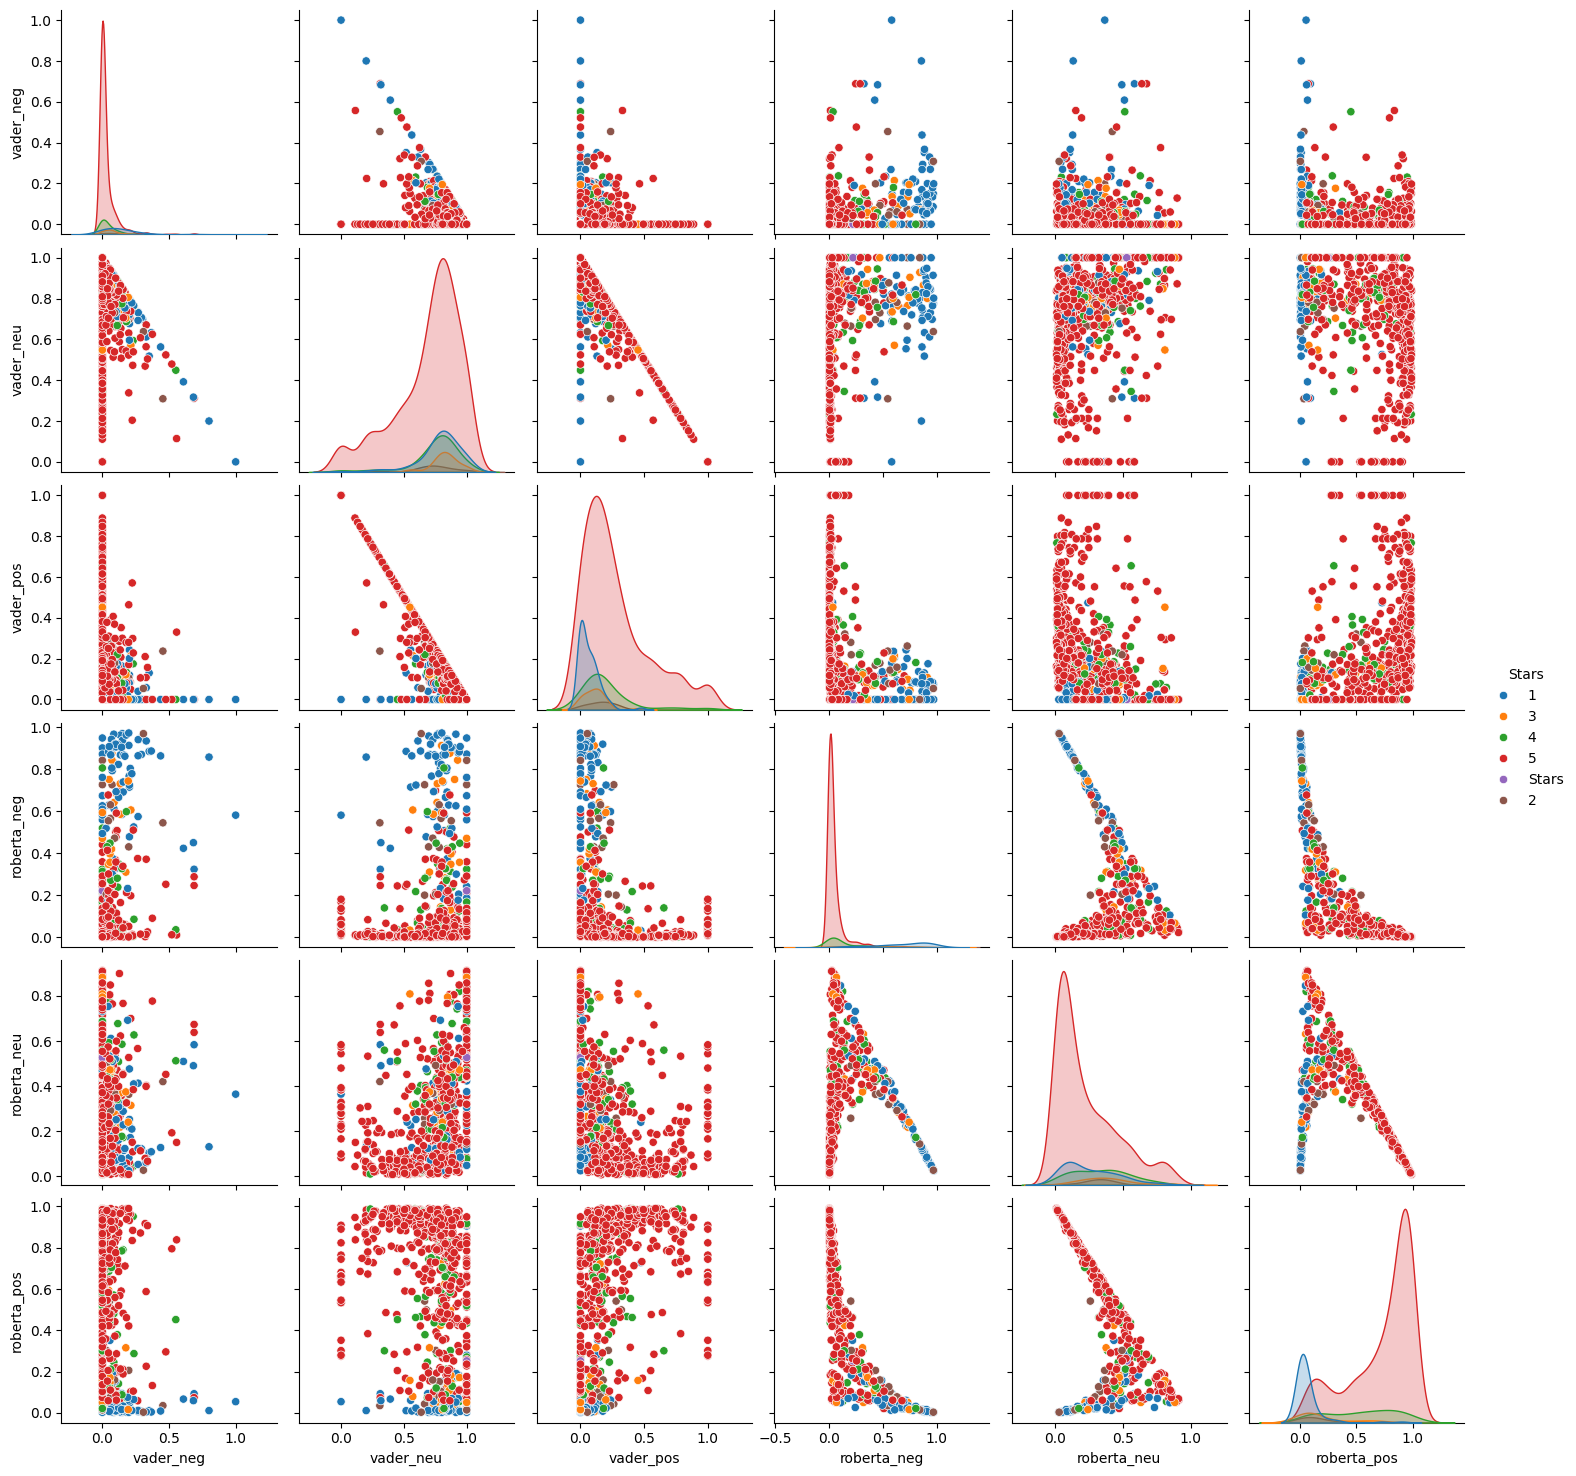

In [25]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Stars',
            palette='tab10')
plt.show()

SENTIMENT DISTRIBUTION

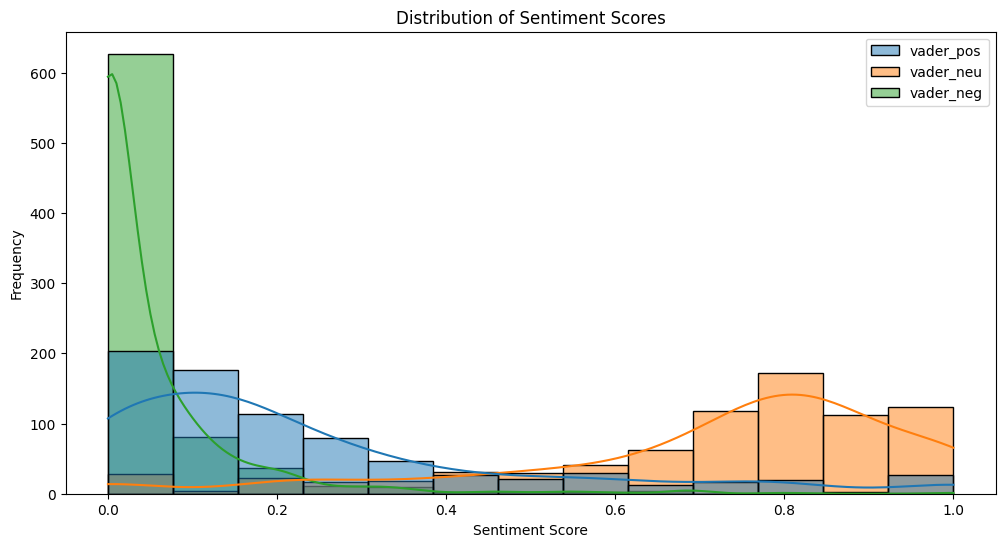

In [26]:
plt.figure(figsize=(12, 6))
sns.histplot(results_df[['vader_pos', 'vader_neu', 'vader_neg']], kde=True)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()

In [27]:
print(results_df['Stars'].unique())
print(results_df['Stars'].dtype)

['1' '3' '4' '5' 'Stars' '2']
object


In [28]:
print(results_df['Stars'].head())

0    1
1    1
2    1
3    1
4    1
Name: Stars, dtype: object


In [29]:
results_df['Stars'] = pd.to_numeric(results_df['Stars'], errors='coerce')

In [30]:
results_df = results_df.dropna(subset=['Stars'])

In [31]:
results_df['Stars'] = results_df['Stars'].astype(int)

<ipython-input-31-6ff007abb8a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['Stars'] = results_df['Stars'].astype(int)


Printing the contradicting results :

In [32]:
filtered_df = results_df.query('Stars == 1').sort_values('roberta_pos', ascending=False)

if not filtered_df.empty:
    # Get the first review's description
    first_review = filtered_df['Description'].values[3]
    print(first_review)
else:
    print("No reviews found with a 1-star rating.")

I purchased this CPU bundled with the ASUS TUF Gaming Z790-Plus WiFi motherboard. That started me chasing my tail for 3 weeks. I ended up soliciting the help of Geek Squad as they had the spares needed to make a proper evaluation. After 5 motherboards (2 manufacturers) and 4 i9-13900K CPU's. We finally found a winner. According to Geek Squads' advanced support, Intel has had a recent production problem with this CPU. They say it's not uncommon to go through 4 or 5 CPU's before finding a good one. Well I saw it with my own eyes. Intel has always had such a good reputation I was reluctant to reach that conclusion. But apparently this is the case. I understand that previous generations are not affected.


In [33]:
filtered_df = results_df.query('Stars == 1').sort_values('vader_pos', ascending=False)

if not filtered_df.empty:
    # Get the first review's description
    first_review = filtered_df['Description'].values[3]
    print(first_review)
else:
    print("No reviews found with a 1-star rating.")

Product never worked after finally building system.Went to Best Buy. Bought another after troubleshooting for days. That one worked.Think I must have gotten someoneâs return item.


In [34]:
filtered_df = results_df.query('Stars == 5').sort_values('vader_neg', ascending=False)

if not filtered_df.empty:
    # Get the first review's description
    first_review = filtered_df['Description'].values[3]
    print(first_review)
else:
    print("No reviews found with a 1-star rating.")

So far no problems and sufficient performance.


In [35]:
filtered_df = results_df.query('Stars == 5').sort_values('roberta_neg', ascending=False)

if not filtered_df.empty:
    # Get the first review's description
    first_review = filtered_df['Description'].values[3]
    print(first_review)
else:
    print("No reviews found with a 1-star rating.")

Remember F and K means no cpu based graphics. So as long as you are installing a gpu, you're fine. Even if your motherboard has video outputs, you cant use them.This only becomes a problem if you have to troubleshoot and it COULD be the gpu.


Code for resolving the issue ( low rating - positive reviews and high rating - negative reviews)

In [36]:
def adjust_sentiment(row):
    if row['Stars'] <= 2 and row['roberta_pos'] > 0.5:
        return 'Negative'
    elif row['Stars'] >= 4 and row['roberta_neg'] > 0.5:
        return 'Positive'
    else:
        return 'Neutral' if row['vader_neu'] > max(row['vader_pos'], row['vader_neg']) else 'Positive' if row['vader_pos'] > row['vader_neg'] else 'Negative'

In [37]:
results_df['Adjusted_Sentiment'] = results_df.apply(adjust_sentiment, axis=1)

In [38]:
results_df.to_csv('adjusted_sentiments.csv', index=False)

The Transformers Pipeline

In [39]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [40]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [41]:
example = df['Description'][500]
print(example)
print(df['Stars'][500])

Very good processor 
5


In [42]:
sent_pipeline(example)

[{'label': 'POSITIVE', 'score': 0.9998599290847778}]